In [2]:
%pylab inline
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle

In [4]:
import os

In [5]:
from tqdm import tqdm_notebook as tqdm

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [7]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mxi = 0.665 # mass of Xi in lattice unit
mpi = 510/ainv # mass of pion in lattice unit
m_red = 0.5 * mxi # reduced mass

In [8]:
from scipy.sparse.linalg import LinearOperator

In [9]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [10]:
# uncertainties is a useful python library to calculate the propagation of the errors
# pip install uncertainties 
from uncertainties import ufloat

In [11]:
from luscher_lib import Kcot_luscher, Luscher_zeta

In [12]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import data

In [13]:
if os.path.isfile('pkls/v0_4gauss_func_prm_av_jk.pkl'):
    with open('pkls/v0_4gauss_func_prm_av_jk.pkl', 'rb') as fin:
        prm_v0_4gauss_avs, prm_v0_4gauss_jks = pickle.load(fin)
else:
    print('Run "Fitting and Scattering phase shift.ipynb"')


In [14]:
if os.path.isfile('pkls/v2_2gauss_func_prm_av_jk.pkl'):
    with open('pkls/v2_2gauss_func_prm_av_jk.pkl', 'rb') as fin:
        prm_v2_2gauss_avs, prm_v2_2gauss_jks = pickle.load(fin)
else:
    print('Run "Fitting and Scattering phase shift.ipynb"')


In [15]:
V4gauss = lambda p, x: (p[0]*np.exp(-p[1]*x**2) + p[2]*np.exp(-p[3]*x**2)
                        + p[4]*np.exp(-p[5]*x**2) + p[6]*np.exp(-p[7]*x**2))
                        
V2gauss = lambda p, x: p[0]*np.exp(-p[1]*(x-p[2])**2) + p[3]*np.exp(-p[4]*(x-p[5])**2)

In [16]:
print(prm_v0_4gauss_jks.keys())

dict_keys([('n2lo', 13), ('n2lo', 14), ('n2lo', 15), ('n2lo', 16), ('wall', 13), ('wall', 14), ('wall', 15), ('wall', 16), ('exp', 13), ('exp', 14), ('exp', 15), ('exp', 16)])


In [17]:
it0 = 13
print(prm_v0_4gauss_avs[('n2lo', it0)].shape)

(8,)


In [18]:
it0 = 13
print(prm_v0_4gauss_jks[('n2lo', it0)].shape)

(20, 8)


In [19]:
bin_num = prm_v0_4gauss_jks[('n2lo', it0)].shape[0]

# check potential

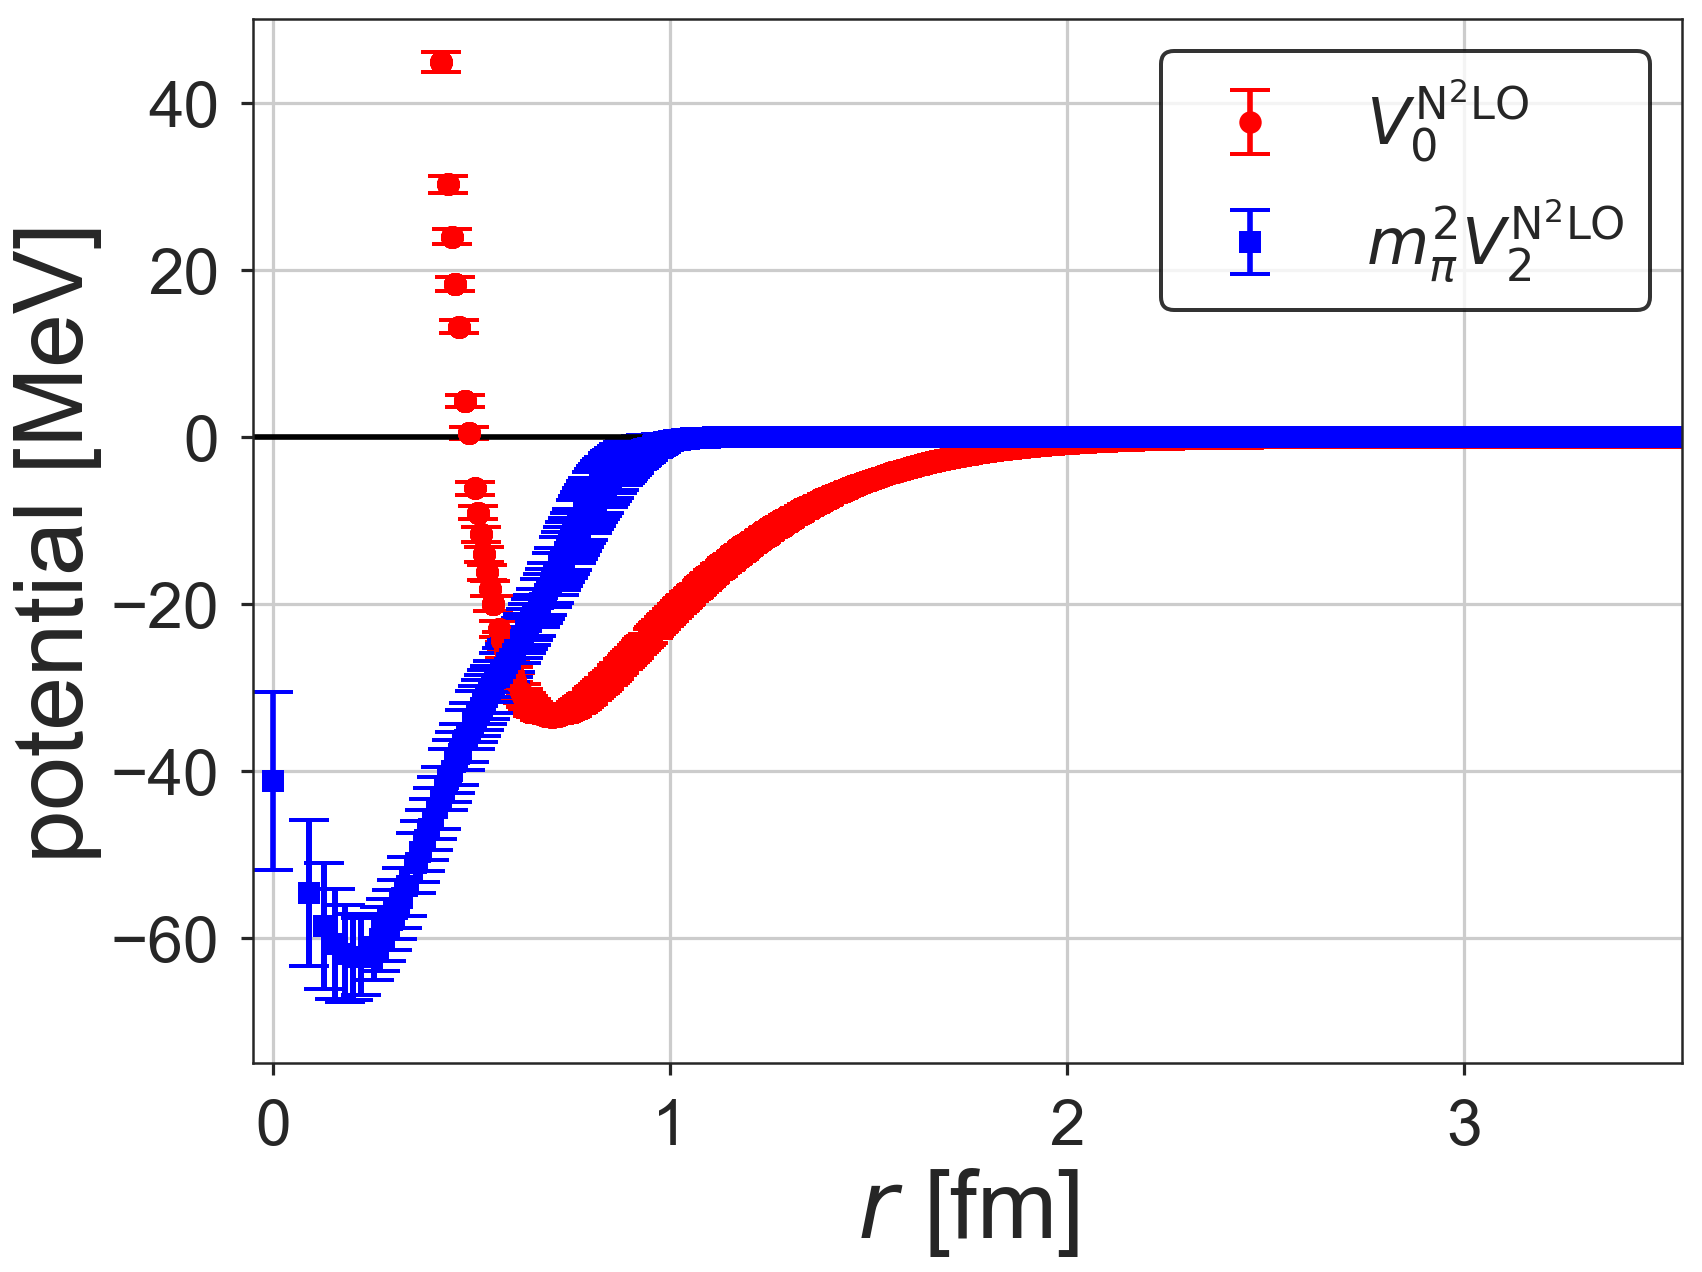

In [20]:
it0 = 13
src = 'n2lo'
fig, ax = plt.subplots()
L = 64
rs = np.array([np.sqrt(ix**2+iy**2+iz**2) + 1.0e-5
              for iz in range(-L//2,L//2) for iy in range(-L//2,L//2)
              for ix in range(-L//2,L//2)]).reshape(L,L,L)
rs = np.roll(rs, (L//2,L//2,L//2), (0, 1, 2)).flatten()

v0_jk = np.array([V4gauss(prm_v0_4gauss_jks[(src, it0)][ibin,:], rs)
                 for ibin in range(bin_num)])

ax.errorbar(rs*lat_unit, v0_jk.mean(axis=0)*ainv,
            v0_jk.std(axis=0)*np.sqrt(bin_num - 1)*ainv,
            fmt='o', color='red', capsize=10, capthick=2, label=r'$V^\mathrm{N^2LO}_0$')

v2_jk = np.array([V2gauss(prm_v2_2gauss_jks[it0][ibin,:], rs)
                 for ibin in range(bin_num)])

ax.errorbar(rs*lat_unit, v2_jk.mean(axis=0)*ainv * mpi**2,
            v2_jk.std(axis=0)*np.sqrt(bin_num - 1)*ainv * mpi**2,
            fmt='s', color='blue', capsize=10, capthick=2, label=r'$m_\pi^2V^\mathrm{N^2LO}_2$')


ax.set_ylim(-75, 50)
ax.set_xlim(-0.05, 3.55)
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'potential [MeV]', size=48)
ax.axhline(0, c='black')
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

# calc. finite volume spectra

In stead of using this part, you may run
```
python solve_eigenvalues.py
```
it generates the same finite volume spectra file.

In [18]:
def A1_projection(wave_in):
    Ns = round(len(wave_in)**(1/3))
    wave = wave_in.reshape(Ns,Ns,Ns)
    wave_tmp1 = (wave[:,:,:] + np.roll(wave,-1,0)[::-1,:,:]
                + np.roll(wave,-1,1)[:,::-1,:]
                + np.roll(wave,-1,2)[:,:,::-1]
                + np.roll(np.roll(wave,-1,0),-1,1)[::-1,::-1,:]
                + np.roll(np.roll(wave,-1,1),-1,2)[:,::-1,::-1]
                + np.roll(np.roll(wave,-1,2),-1,0)[::-1,:,::-1]
                + np.roll(np.roll(np.roll(wave,-1,0),-1,1),-1,2)[::-1,::-1,::-1])/8.0
    wave_tmp2 = (wave_tmp1 
                + np.swapaxes(wave_tmp1,0,1)
                + np.swapaxes(wave_tmp1,1,2)
                + np.swapaxes(wave_tmp1,2,0)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,1),1,2)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,2),2,1))/6.0e0

    return wave_tmp2.flatten()

In [66]:
def solve_eigen(ibin, L=40, Nev=5, it0=13):
    print(ibin)
    rs = np.array([np.sqrt(ix**2+iy**2+iz**2) + 1.0e-5
                  for iz in range(-L//2,L//2) for iy in range(-L//2,L//2)
                  for ix in range(-L//2,L//2)]).reshape(L,L,L)
    rs = np.roll(rs, (L//2,L//2,L//2), (0, 1, 2)).flatten()
    
    pot_v0 = V4gauss(prm_v0_4gauss_jks[('n2lo',it0)][ibin,:], rs)
    pot_v2 = V2gauss(prm_v2_2gauss_jks[it0][ibin,:], rs)

    lap = lambda vec: - 6.0*vec + ( np.roll(vec,+1,0) + np.roll(vec,-1,0) 
                                  + np.roll(vec,+1,1) + np.roll(vec,-1,1) 
                                  + np.roll(vec,+1,2) + np.roll(vec,-1,2) )

    Vol = L**3

    H = LinearOperator((Vol,Vol), 
        matvec = lambda vec: (pot_v0 * vec 
          + lap(vec.reshape(L,L,L)).flatten()*(pot_v2 - 1/(2.0*m_red))), 
        dtype='float64')

    vals, vecs = scipy.sparse.linalg.eigs(H, which='SM', k = Nev)
    return vals, vecs


In [67]:
vals_jk = {}
vecs_jk = {}

In [68]:
L = 40
vals_jk[L] = []
vecs_jk[L] = []
for ibin in tqdm(range(bin_num)):
    _vals, _vecs = solve_eigen(ibin, L=L)
    vals_jk[L].append(_vals)
    vecs_jk[L].append(_vecs)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



In [69]:
L = 48
vals_jk[L] = []
vecs_jk[L] = []
for ibin in tqdm(range(bin_num)):
    _vals, _vecs = solve_eigen(ibin, L=L)
    vals_jk[L].append(_vals)
    vecs_jk[L].append(_vecs)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



In [70]:
L = 64
vals_jk[L] = []
vecs_jk[L] = []
for ibin in tqdm(range(bin_num)):
    _vals, _vecs = solve_eigen(ibin, L=L)
    vals_jk[L].append(_vals)
    vecs_jk[L].append(_vecs)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



In [71]:
for L in [40, 48, 64]:
    vals_jk[L] = np.array(vals_jk[L])
    vecs_jk[L] = np.array(vecs_jk[L])

In [72]:
vecs_jk[64].shape

(20, 262144, 5)

In [73]:
vals_jk[64].shape

(20, 5)

In [74]:
eigens_jk = {}
for L in [40, 48, 64]:
    eigens_jk[L] = vals_jk[L][:,0]

In [113]:
eigen_scat = vals_jk[64][:,1]

In [112]:
vals_jk[64][:,1]*ainv

array([28.72525276+0.j, 28.68773358+0.j, 28.68026615+0.j, 28.65233684+0.j,
       28.65132012+0.j, 28.68616334+0.j, 28.71343319+0.j, 28.7393963 +0.j,
       28.73416646+0.j, 28.68447422+0.j, 28.7947315 +0.j, 28.75550488+0.j,
       28.72952221+0.j, 28.69324179+0.j, 28.65848401+0.j, 28.69139742+0.j,
       28.74312094+0.j, 28.7366723 +0.j, 28.67623512+0.j, 28.65050732+0.j])

In [114]:
with open('pkls/finite_volume_spectra_n2lo.pkl', 'wb') as fout:
    pickle.dump((eigens_jk, eigen_scat), fout)

# volume dependence

In [21]:
with open('pkls/finite_volume_spectra_n2lo.pkl', 'rb') as fin:
    eigens_jk, eigen_scat = pickle.load(fin)

scat. length = 0.961+/-0.033 fm
(a0mpi)^{-1} = 0.402+/-0.014


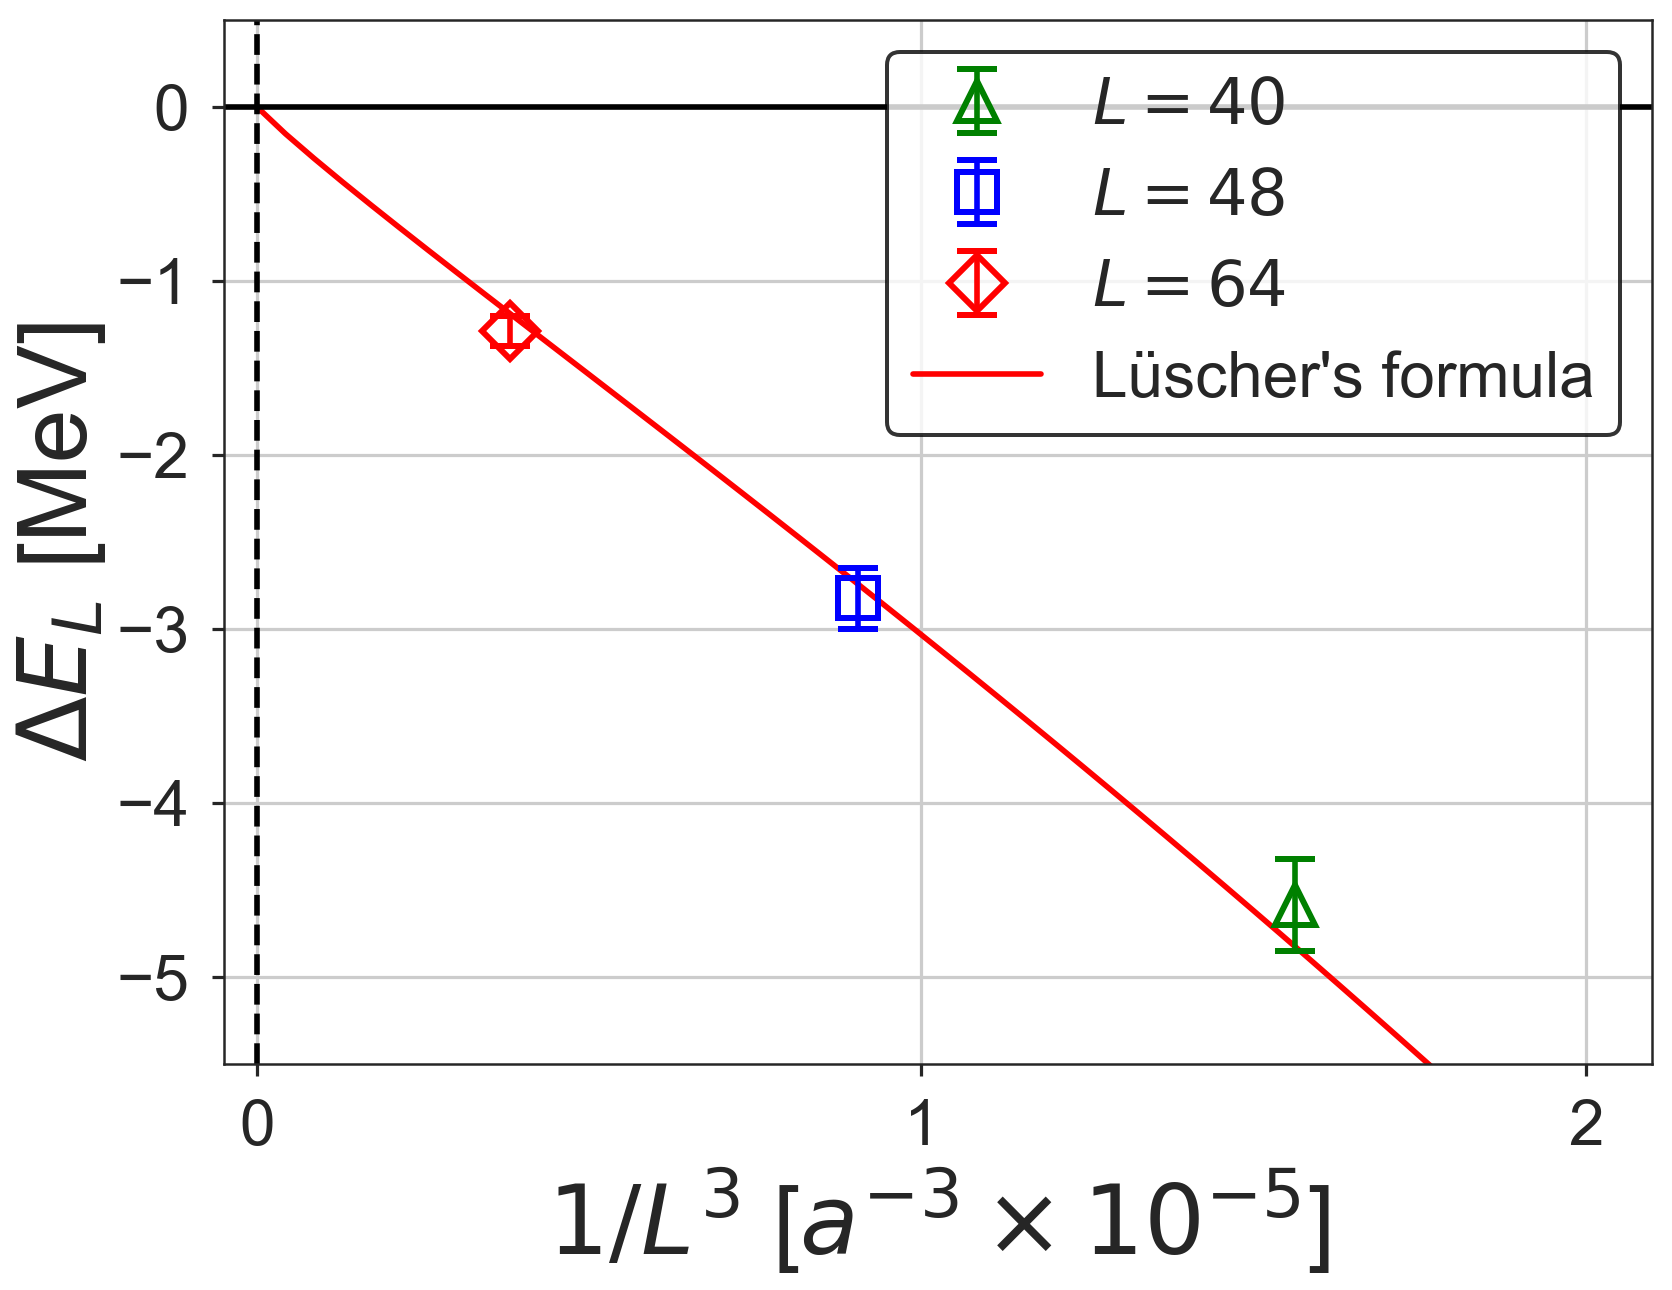

In [22]:
Ls = np.array([40, 48, 64])
gs = np.array([np.real(eigens_jk[L]).mean()*ainv for L in Ls])
gs_err = np.array([np.real(eigens_jk[L]).std() * np.sqrt(bin_num - 1) * ainv for L in Ls])

fig, ax = plt.subplots()

for L, ith, c, sym in zip([40, 48, 64], [0, 1, 2], ['green', 'blue', 'red'], 
                          ['^', 's', 'D']):
    ax.errorbar(1/L**3, gs[ith], gs_err[ith], fmt=sym, ms=20, capsize=10, capthick=2.0, 
                c=c, mec=c, mew=3.0, mfc='none', label=rf'$L = {L}$')


p0 = [1.0]
#mxi = 1.45703e3/ainv # lat_unit
c1 = -2.837297
c2 = 6.375183
n3lo = lambda p,x: ( - 2.0*np.pi*p[0]/(0.5*mxi)/x**3 * (1 + c1*p[0]/x + c2*(p[0]/x)**2) 
                    )
errfunc = lambda p,y,x,err: (n3lo(p,x)-y)/err

param_output = scipy.optimize.leastsq(errfunc, p0, 
                                      args=(gs/ainv, Ls, gs_err/ainv), full_output = True)
#print(param_output)
xmin, xmax = 1.0e-10, 2.1e-5
xls = np.linspace(xmin,xmax)

a0 = ufloat(param_output[0][0], np.sqrt(param_output[1][0,0]))
print('scat. length = {:4.3f} fm'.format(a0 * lat_unit))
a0mpi = a0 * mpi 
print('(a0mpi)^{{-1}} = {:4.3f}'.format(1.0/a0mpi))
#if output == True:
#ax.set_title(rf'$(a_0 m_\pi)^{{-1}} = {(1.0/a0mpi).n:3.4f} \pm {(1.0/a0mpi).s:3.4f}$',
#                fontsize=48)

#ax.errorbar([0], param_output[0][1]*ainv,
#            np.sqrt(param_output[1][1,1])*ainv, fmt='o', c='black', ms=20, lw=8, 
#            capsize=10, capthick=2, mfc='white', mec='black', mew=4.0,
#            label=r'$L \rightarrow \infty$', zorder=3)
ax.plot(xls, n3lo(param_output[0],1/xls**(1.0/3.0))*ainv,ls='-',color='red', 
        label=r"Lüscher's formula", zorder=1)

ax.set_xticks([0,1e-5,2.0e-5])
ax.set_xticklabels(['0', '1', '2'])
ax.axhline(0,color='black')
ax.axvline(0,color='black', ls='--')
ax.set_ylim(-5.5,0.5)
ax.set_xlim(-0.5e-6,xmax)

ll, hh = ax.get_legend_handles_labels()
ll = [ll[i] for i in [1,2,3,0]]
hh = [hh[i] for i in [1,2,3,0]]

#ax.legend(ll, hh, loc='lower left', fontsize=32)
ax.set_xlabel(r'$1/L^3$ [$a^{-3} \times {10}^{-5}$]', fontsize=48)
ax.set_ylabel(r'$\Delta E_L$ [MeV]', fontsize=48)
leg = ax.legend(ll, hh, loc='upper right', frameon=True, fontsize=32)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
fig.savefig('../figs/finite_volume_method/dE0_Ldep.pdf', bbox_inches='tight')

# Finite volume method

## import scattering phase shift from potential

In [23]:
fname = 'pkls/k2s_deltas_jk.pkl'
if os.path.isfile(fname):
    with open(fname, 'rb') as fin:
        k2s_deltas_jk = pickle.load(fin)
else:
    print('Run "Fitting and Scattering phase shift.ipynb"')

In [24]:
k2s_phase = k2s_deltas_jk[0][('n2lo_w_v2', it0)]
delta_jk = k2s_deltas_jk[1][('n2lo_w_v2', it0)]

## evaluate scattering phase shift from finite volume formula

In [25]:
kcs = {}
for L in [40, 48, 64]:
    kcs[L] = Kcot_luscher(L, mxi, mxi, mpi)

In [26]:
k2mpi2s = {}
kcot_mpis = {}
k2mpi2 = {}
kcot_mpi = {}
Ls = [40, 48, 64]

for L in Ls:
    k2mpi2s[L] = []
    kcot_mpis[L] = []
    tm = np.real(eigens_jk[L]).mean()
    te = np.real(eigens_jk[L]).std() * np.sqrt(bin_num - 1)
    print('L = {}, delta E range {:3.2f} MeV -> {:3.2f} MeV'.format(L, (tm-te)*ainv, (tm+te)*ainv))
    k2 = kcs[L].tok2(tm)
    k2mpi2[L] = [k2/(mpi**2)]
    kcot_mpi[L] = [kcs[L].kcot(k2)]
    for dE in tqdm(np.linspace(tm - te, tm + te)):
        k2 = kcs[L].tok2(dE)
        kcot_mpis[L].append(kcs[L].kcot(k2))
        k2mpi2s[L].append(k2/(mpi**2))


L = 40, delta E range -4.85 MeV -> -4.32 MeV


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


L = 48, delta E range -3.00 MeV -> -2.65 MeV


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


L = 64, delta E range -1.38 MeV -> -1.20 MeV


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

In [27]:
tm = np.real(eigen_scat).mean()
te = np.real(eigen_scat).std() * np.sqrt(bin_num - 1)

print('L = {}, delta E range {:3.2f} MeV -> {:3.2f} MeV'.format(L, (tm-te)*ainv, (tm+te)*ainv))
k2 = kcs[L].tok2(tm)
k2mpi2_scat = [k2/(mpi**2)]
kcot_mpi_scat = [kcs[L].kcot(k2)]
kcot_mpis_scat = []
k2mpi2s_scat = []
for dE in tqdm(np.linspace(tm - te, tm + te)):
    k2 = kcs[L].tok2(dE)
    kcot_mpis_scat.append(kcs[L].kcot(k2))
    k2mpi2s_scat.append(k2/(mpi**2))


L = 64, delta E range 28.54 MeV -> 28.87 MeV


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

In [28]:
# evaluate the finite volume constraint curves
k2_tot = np.linspace(-0.08, -1.0e-5)*mpi**2
kcot_tot = {}
for L in tqdm(Ls):
    tmp = []
    for k2 in k2_tot:
        tmp.append(kcs[L].kcot(k2))
    kcot_tot[L] = np.array(tmp)
    
k2_tot_scat = np.linspace(0.02, 0.175)*mpi**2
L = 64
tmp = []
for k2 in k2_tot_scat:
    tmp.append(kcs[L].kcot(k2))

kcot_tot_scat = np.array(tmp)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

In [29]:
def plot_kcot_from_fv_method(ax):
    for L, sym, c in zip(Ls, ['^', 's', 'D'], ['green', 'blue', 'red']):
        ax.plot(k2_tot/mpi**2, kcot_tot[L], c='black', ls='--', lw=2)
        ax.plot(k2mpi2[L], kcot_mpi[L], marker=sym, color='white', mew=3.0, mec=c, ms=20,
               label=rf'$L = {L}$', zorder=5)
        ax.plot(k2mpi2s[L], kcot_mpis[L], color='white', lw=10) #, label=rf'$L = {L}$')
        ax.plot(k2mpi2s[L], kcot_mpis[L], color=c, lw=8) #, label=rf'$L = {L}$')

        ax.plot(k2_tot_scat/mpi**2, kcot_tot_scat, c='black', ls='--', lw=2)
        ax.plot(k2mpi2_scat, kcot_mpi_scat, 'D', c='white', mew=3.0, mec=c, ms=20, zorder=5)
        ax.plot(k2mpi2s_scat, kcot_mpis_scat, color='red', lw=10)

    xls = np.concatenate([np.linspace(-0.1, -1.0e-2),
                      np.linspace(-1.0e-2, -1.0e-5)])
    ax.plot(xls, - np.sqrt(-xls), c='black', lw=5, label=r'$-\sqrt{-(k/m_\pi)^2}$')

In [31]:
def plot_kcot_from_pot(ax):
    k2_pot = k2s_phase/mpi**2
    kc_pot = (np.sqrt(k2s_phase)/np.tan(delta_jk)).mean(axis=0)/mpi
    kc_pot_err = (np.sqrt(k2s_phase)/np.tan(delta_jk)).std(axis=0)*np.sqrt(bin_num - 1)/mpi
    ax.fill_between(k2_pot, kc_pot - kc_pot_err, kc_pot + kc_pot_err,
                    color='blue',
                    alpha=0.8, label=r'HAL QCD pot.')
    ax.plot(k2_pot, kc_pot - kc_pot_err, color='black', zorder=1)
    ax.plot(k2_pot, kc_pot + kc_pot_err, color='black', zorder=1)

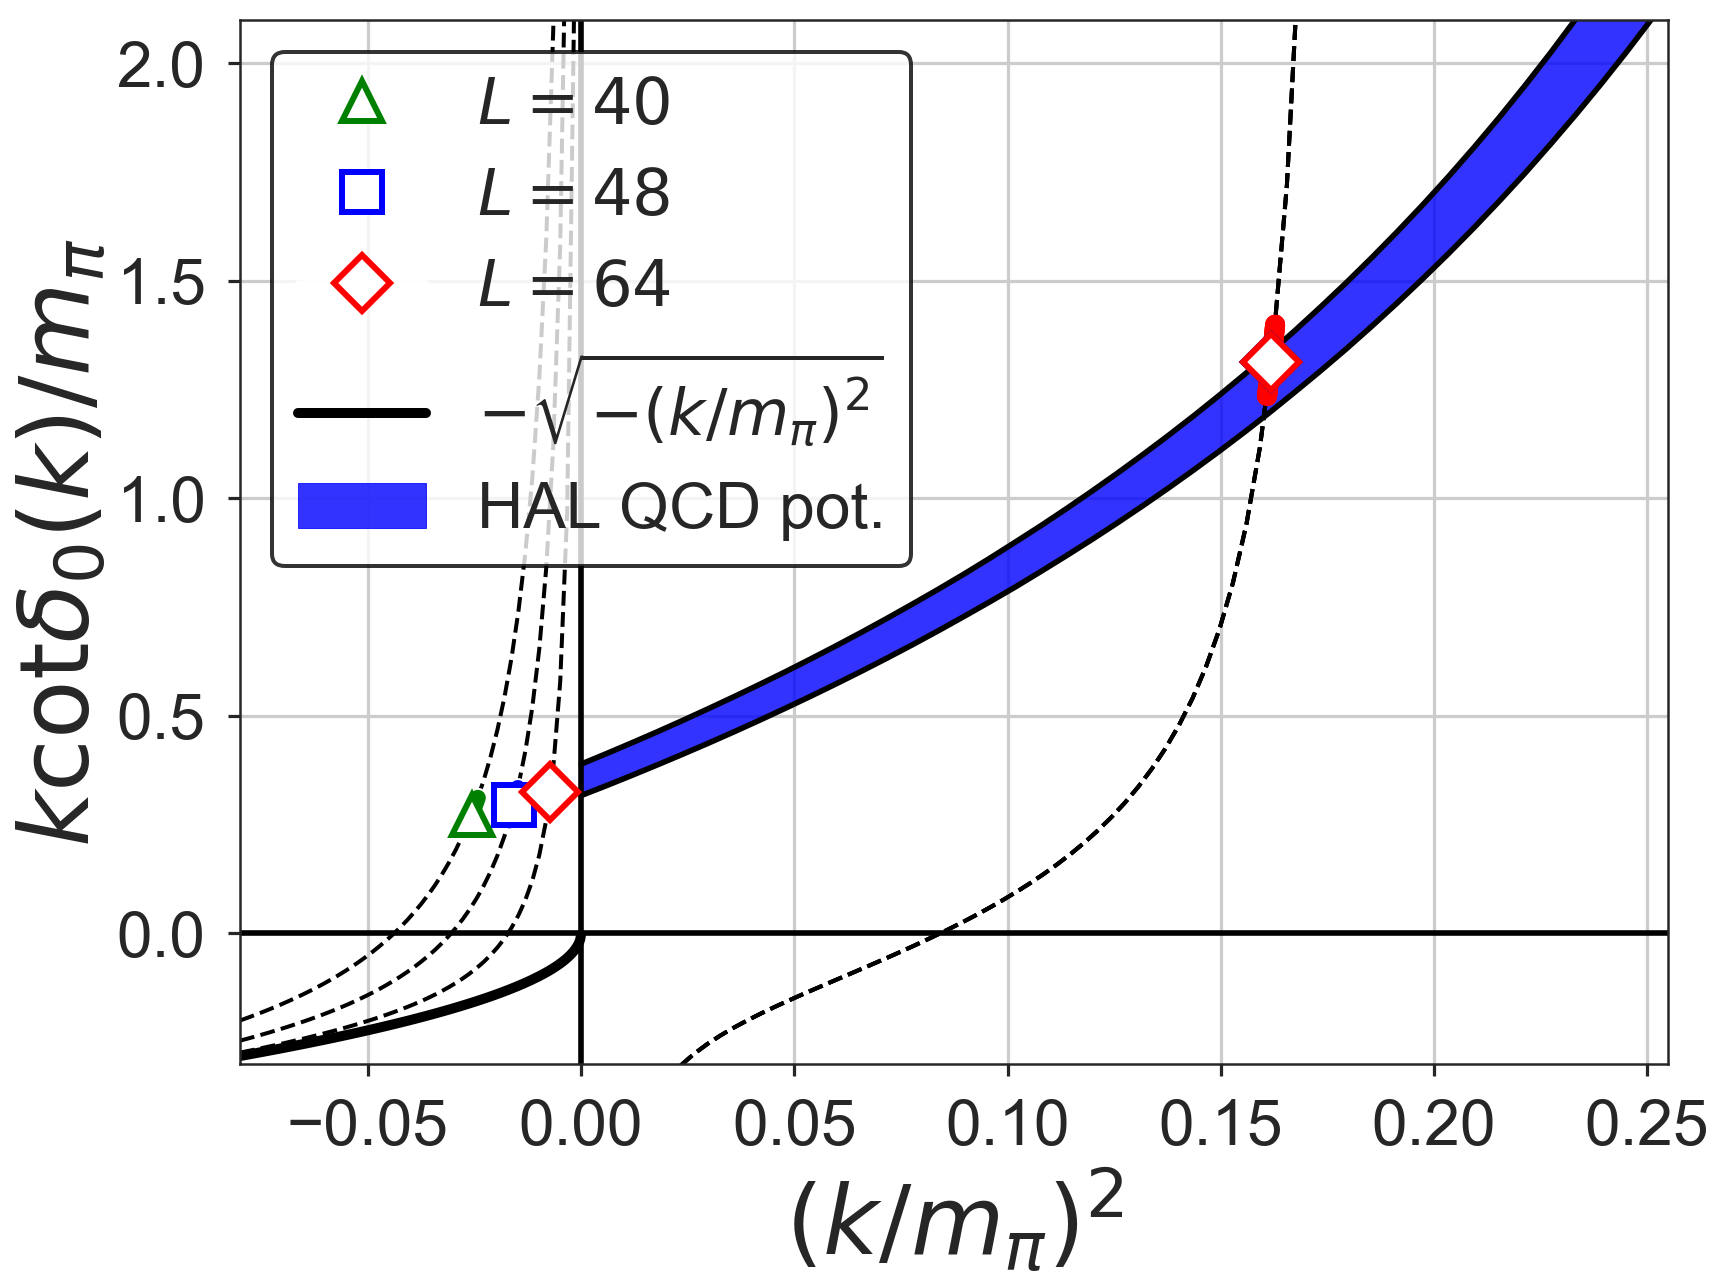

In [32]:
fig, ax = plt.subplots()

plot_kcot_from_fv_method(ax)
plot_kcot_from_pot(ax)

    
ax.set_xlim(-0.08, 0.255)
ax.set_ylim(-0.3, 2.1)
ax.set_xlabel(r'$(k/m_\pi)^2$', size=48)
ax.set_ylabel(r'$k\cot\delta_0(k)/m_\pi$', size=48)
ax.axhline(0, c='black')
ax.axvline(0, c='black')
leg = ax.legend(loc='upper left', frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
#fig.savefig('figs/luscher_from_hal/kcot_vs_k2.pdf', bbox_inches='tight')

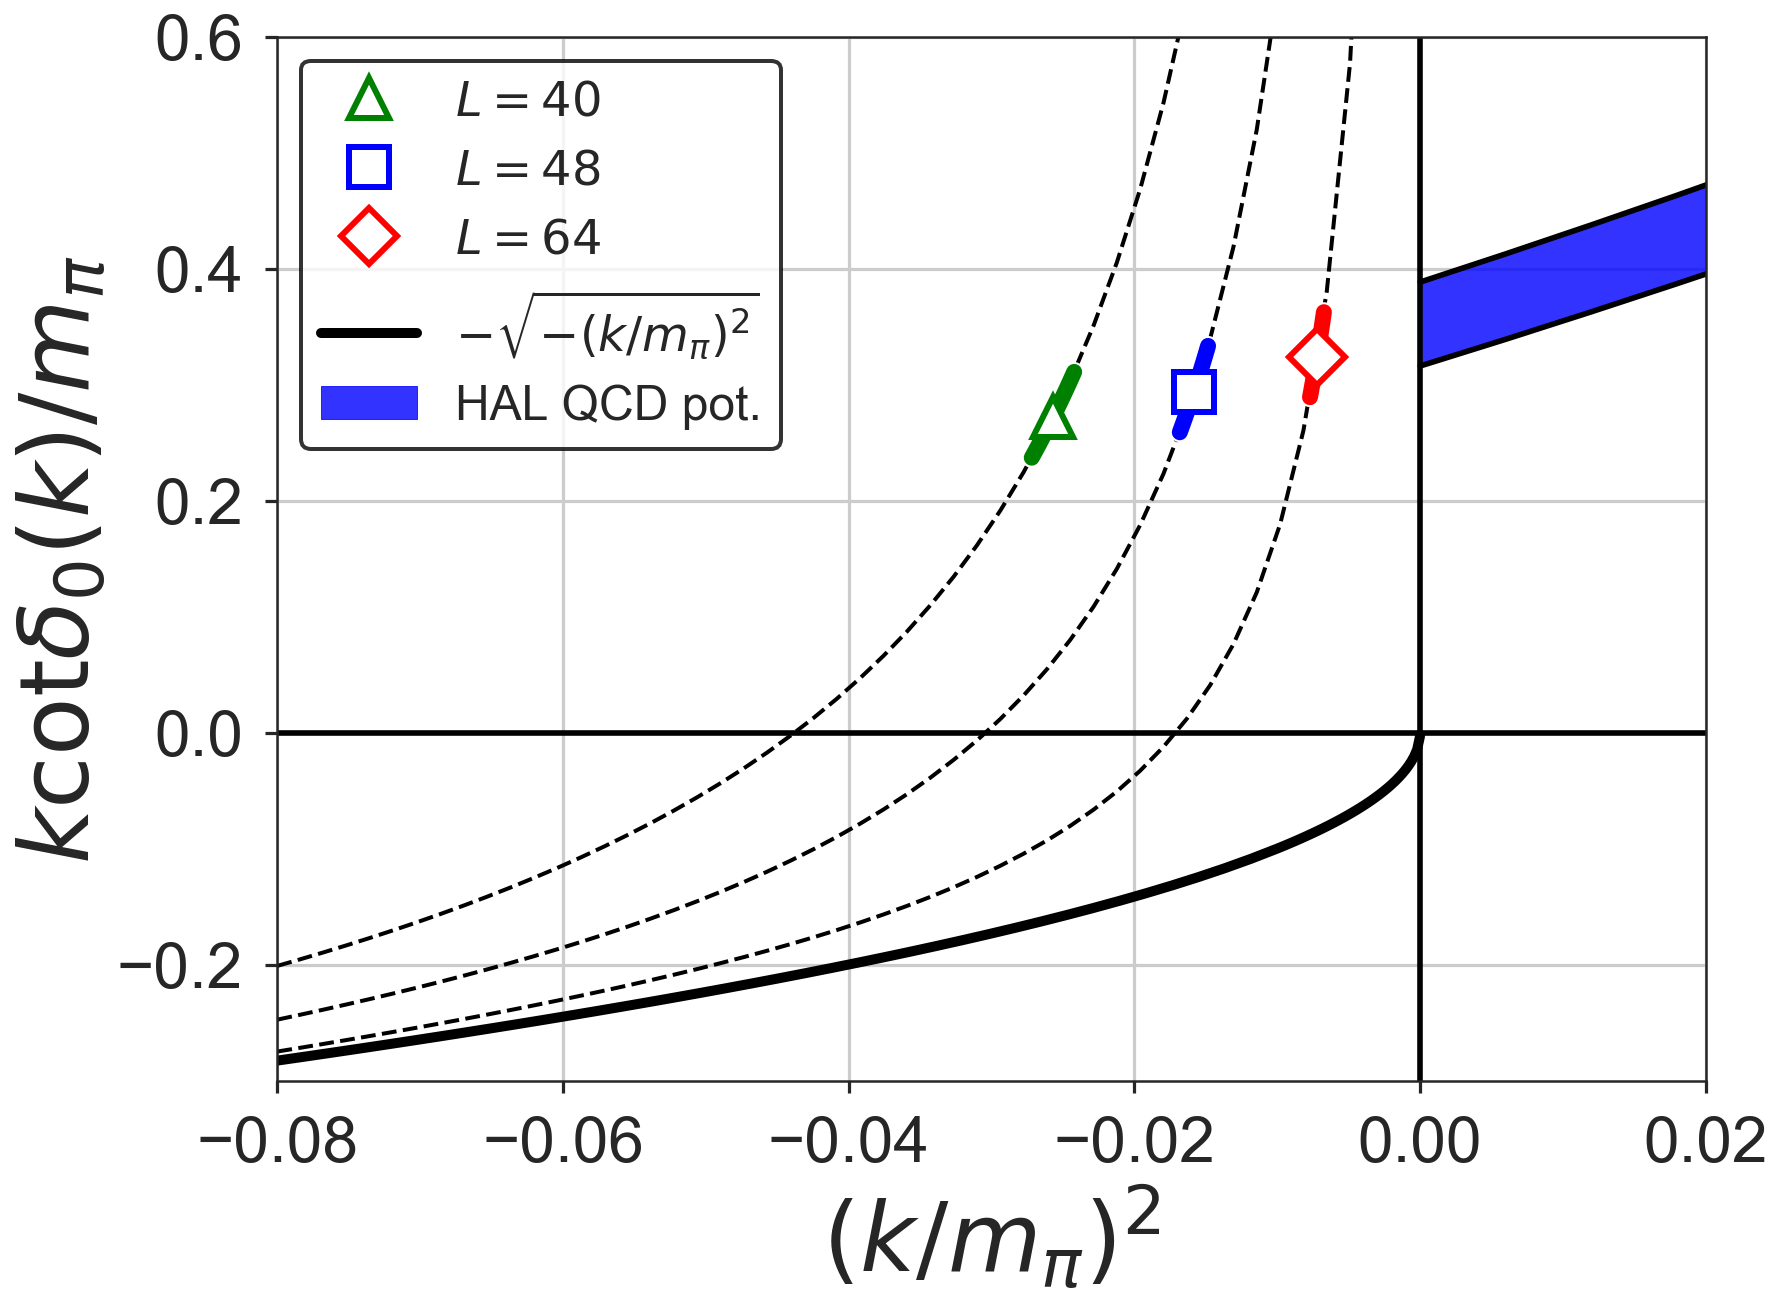

In [34]:
fig, ax = plt.subplots()

plot_kcot_from_fv_method(ax)
plot_kcot_from_pot(ax)

ax.set_xlim(-0.08, 0.02)
ax.set_ylim(-0.3, 0.6)
ax.set_xlabel(r'$(k/m_\pi)^2$', size=48)
ax.set_ylabel(r'$k\cot\delta_0(k)/m_\pi$', size=48)
ax.axhline(0, c='black')
ax.axvline(0, c='black')
leg = ax.legend(loc='upper left', frameon=True, fontsize=24)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
#fig.savefig('figs/luscher_from_hal/kcot_vs_k2.pdf', bbox_inches='tight')

# ERE fitting

In order to fit the effective range expansion, we interpolate the finite volume constraint by using spline curves.

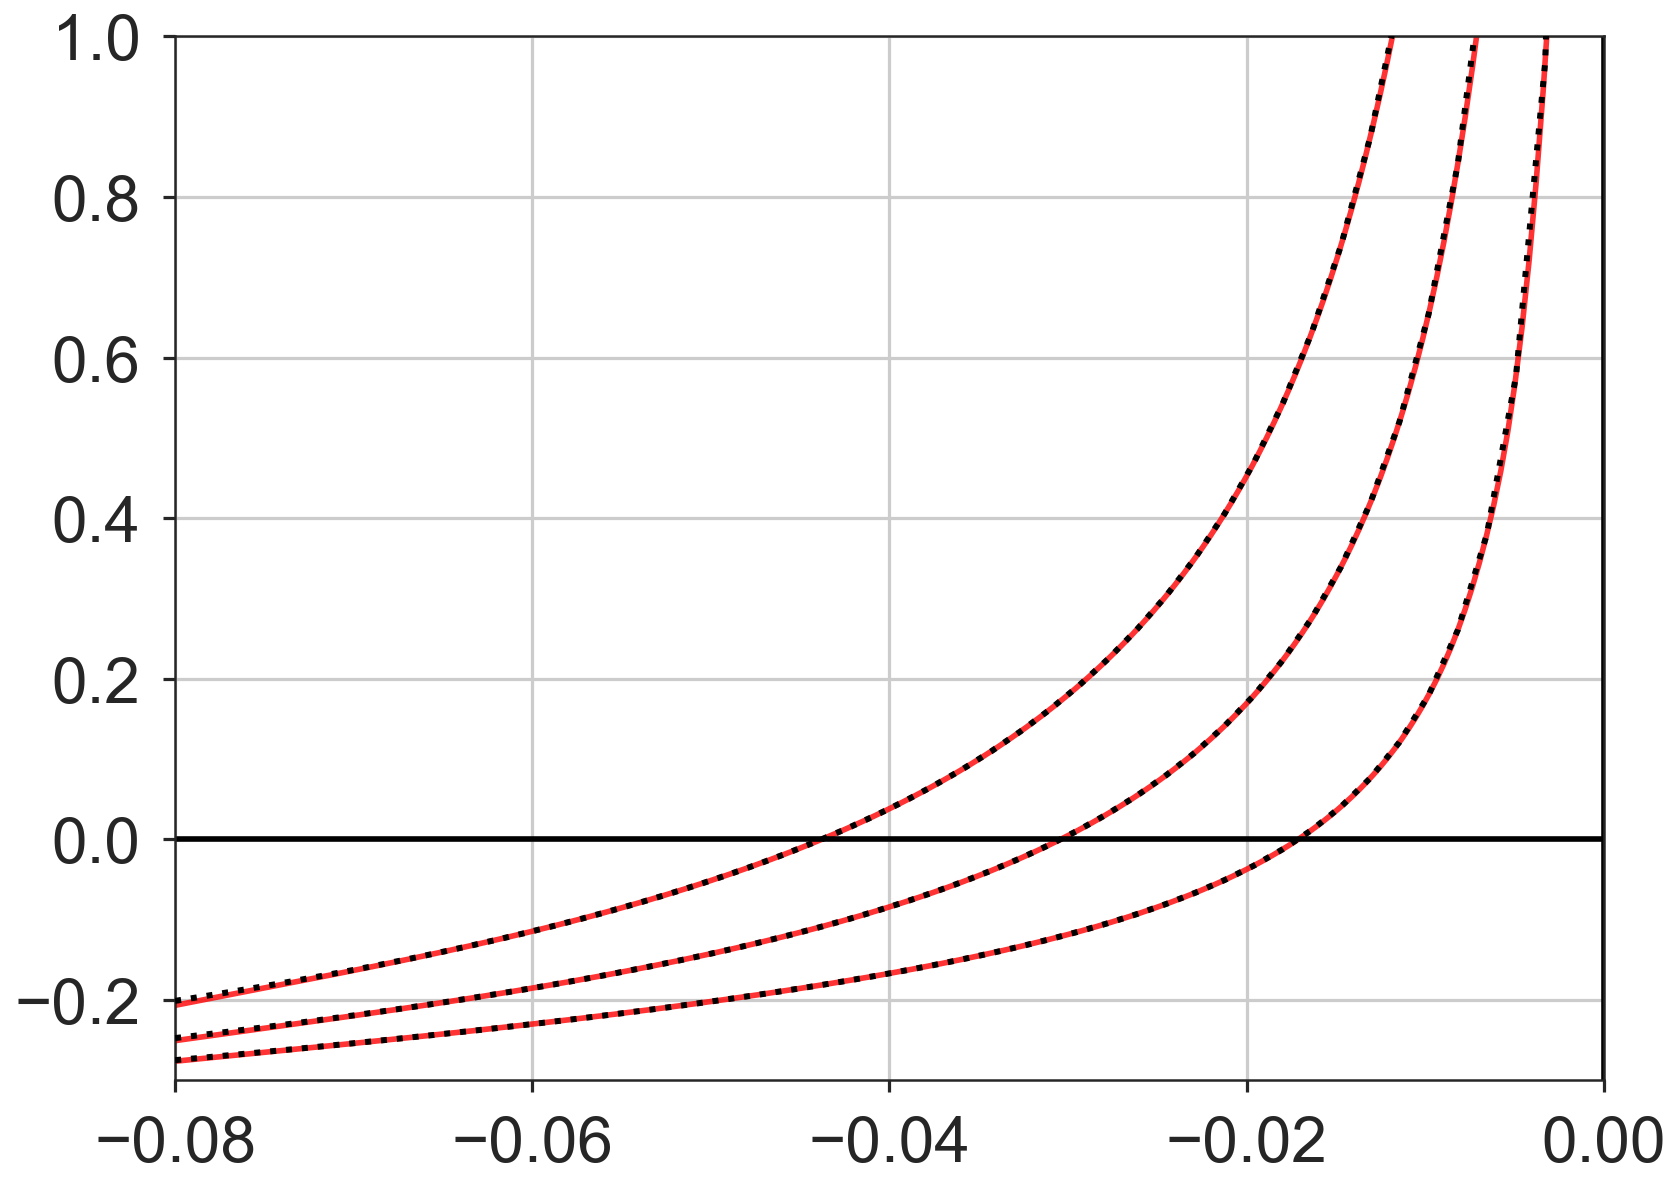

In [35]:
# for k^2 < 0
fig, ax = plt.subplots()
ll = {}
for L in [40, 48, 64]:
    ax.plot(k2_tot/mpi**2, kcot_tot[L], c='black', ls=':', lw=3, zorder=3)
    xs = k2_tot/mpi**2
    ys = kcot_tot[L]
    mask = (ys < 1.0) &  (xs > -0.06)
    ll[L] = InterpolatedUnivariateSpline(xs[mask], ys[mask])
    xls = np.linspace(-0.08, -1.0e-3, 200)
    ax.plot(xls, ll[L](xls), color='red', zorder=1, alpha=0.8)

ax.set_xlim(-0.08, 0)
ax.set_ylim(-0.3, 1.0)
ax.axhline(0, c='black')
ax.axvline(0, c='black')

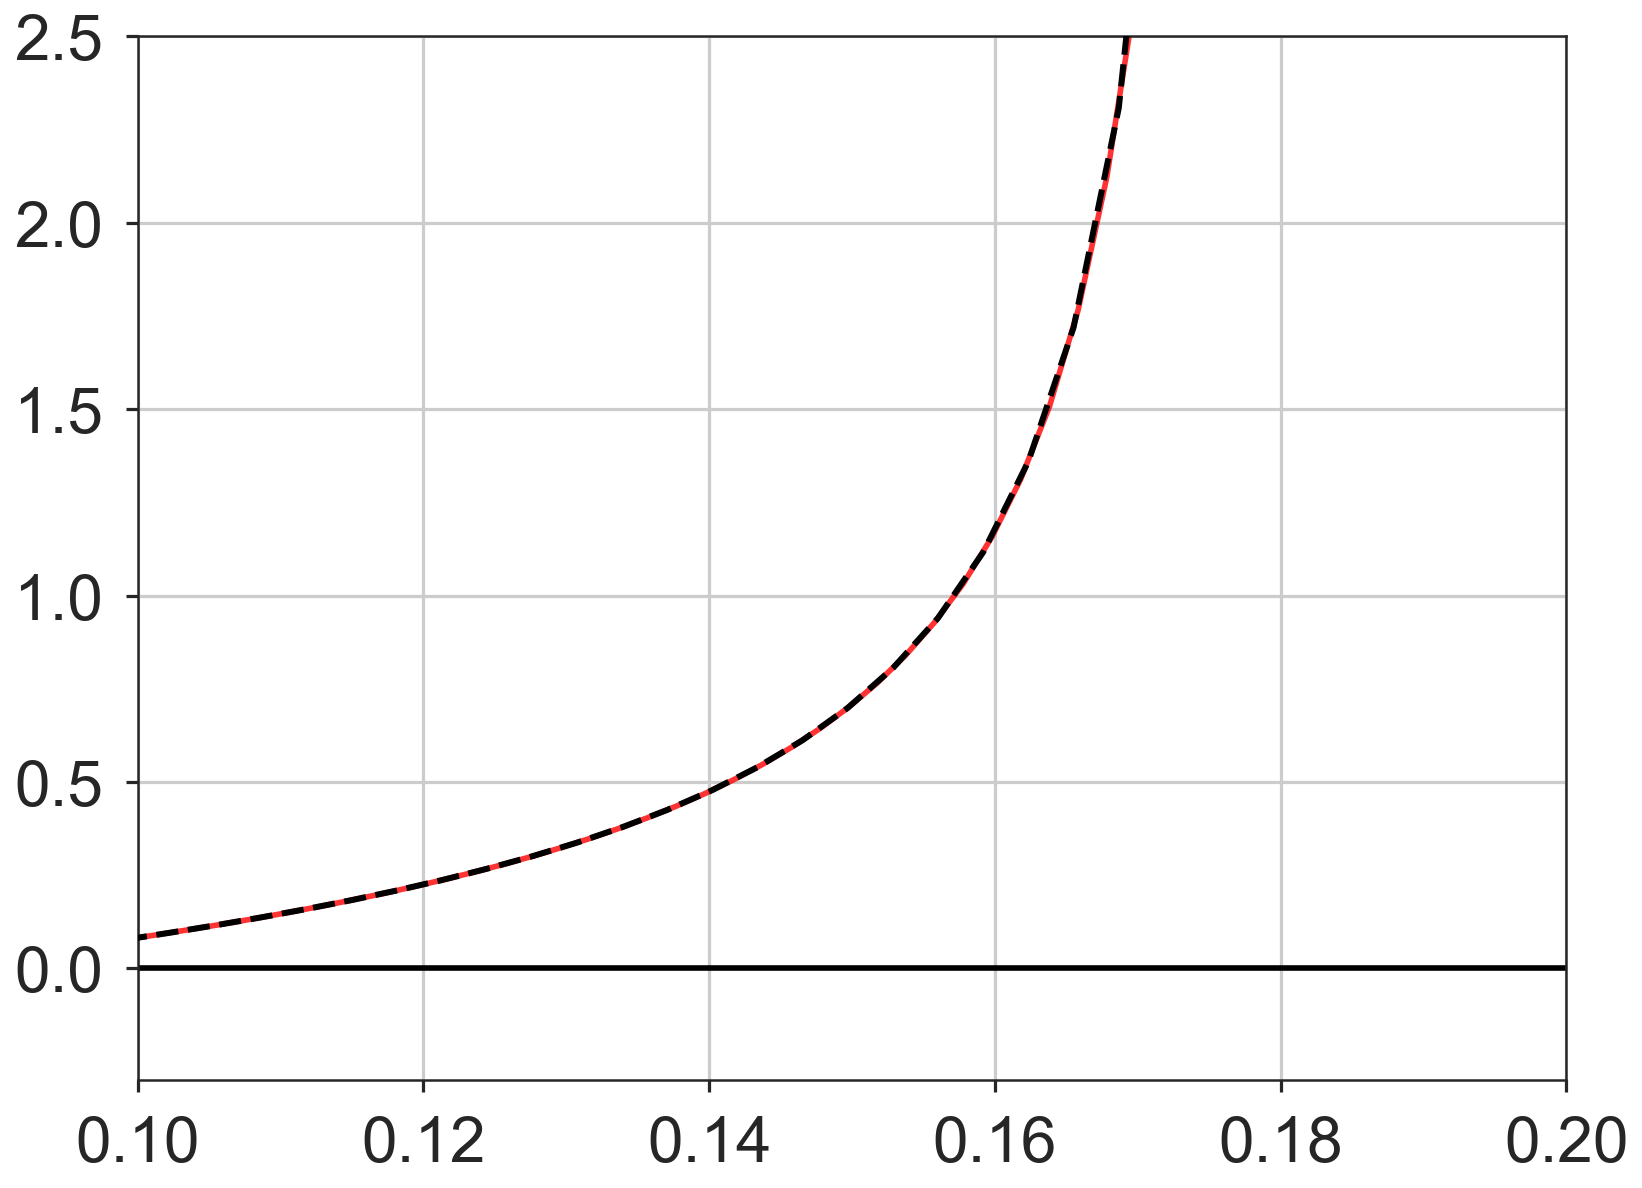

In [36]:
# for k^2 > 0
fig, ax = plt.subplots()

ax.plot(k2_tot_scat/mpi**2, kcot_tot_scat, c='black', ls='--', lw=3, zorder=3)
xs = k2_tot_scat/mpi**2
ys = kcot_tot_scat
mask = (xs > 0.1) & (ys < 2.5)
ll['scat'] = InterpolatedUnivariateSpline(xs[mask], ys[mask])
xls = np.linspace(1.0e-3, 0.20, 100)
ax.plot(xls, ll['scat'](xls), color='red', zorder=1, alpha=0.8)

ax.set_xlim(0.1, 0.2)
ax.set_ylim(-0.3, 2.5)
ax.axhline(0, c='black')
ax.axvline(0, c='black')


[20.63577655]
[7.35863655]
[3.98683415]
[9.75760494]


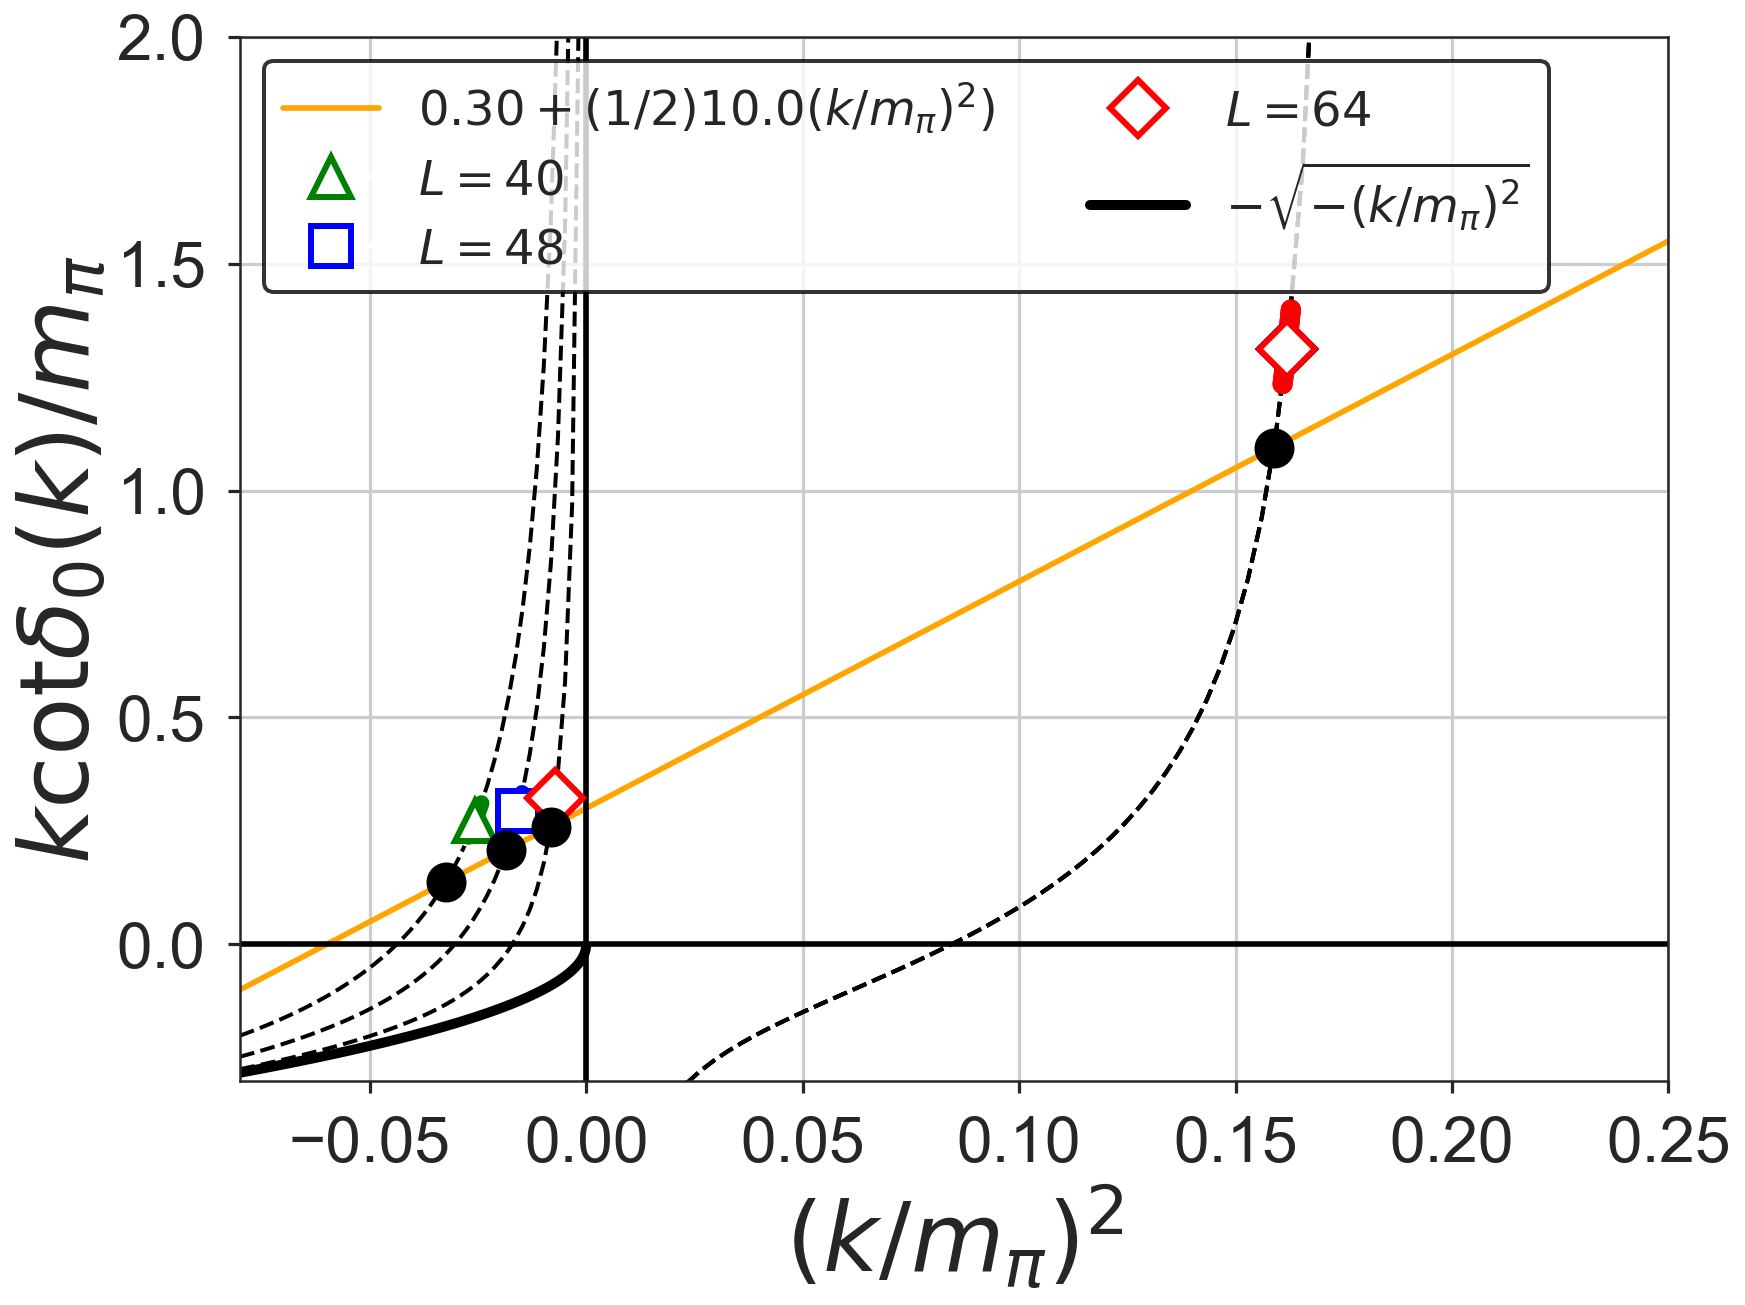

In [37]:
def check_ere_intersection(ere_prm):
    fig, ax = plt.subplots()
    ere = lambda k2: ere_prm[0] + 0.5*ere_prm[1]*k2
    for L in [40, 48, 64, 'scat']:
        ll_L = ll[L]
        intersect = lambda k2: ere(k2) - ll_L(k2)
        sol = scipy.optimize.root(intersect, -0.02)
    #    print(sol.x)
        if L == 'scat':
            v_mean = k2mpi2_scat
            v_err = k2mpi2s_scat[0] - v_mean
        else:
            v_mean = k2mpi2[L]
            v_err = k2mpi2s[L][0] - v_mean
        print((sol.x - v_mean)**2/(v_err**2))
        ax.plot(sol.x, ll_L(sol.x), 'ko', ms=20, zorder=10)
    xls = np.linspace(-0.08, 2.5)
    ax.plot(xls, ere(xls), color='orange', 
            label=r'${:.2f} + (1/2){:.1f}(k/m_\pi)^2)$'.format(ere_prm[0], ere_prm[1]))
    ax.set_xlim(-0.08, 0.25)
    ax.set_ylim(-0.3, 2.0)
    ax.axhline(0, c='black')
    ax.axvline(0, c='black')

    plot_kcot_from_fv_method(ax)
    leg = ax.legend(ncol=2, frameon=True, fontsize=24)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    ax.set_xlabel(r'$(k/m_\pi)^2$', size=48)
    ax.set_ylabel(r'$k\cot\delta_0(k)/m_\pi$', size=48)
    
check_ere_intersection([0.3, 10])

In [38]:
def eval_chi2(ere_prm):
    ere = lambda k2: ere_prm[0] + 0.5*ere_prm[1]*k2
    chi2 = []
    for L in [40, 48, 64]:
        ll_L = ll[L]
        intersect = lambda k2: ere(k2) - ll_L(k2)
        sol = scipy.optimize.root(intersect, -0.02)
        v_mean = k2mpi2[L]
        v_err = k2mpi2s[L][0] - v_mean
        chi2.append((sol.x - v_mean)**2/(v_err**2))
        
    L = 'scat'
    ll_L = ll[L]
    intersect = lambda k2: ere(k2) - ll_L(k2)
    sol = scipy.optimize.root(intersect, 0.15)

    v_mean = k2mpi2_scat
    v_err = k2mpi2s_scat[0] - v_mean
    chi2.append((sol.x - v_mean)**2/(v_err**2))
    
    return np.array(chi2).sum()

eval_chi2([0.40, 12])

2.5153046559679586

In [39]:
# evaluate chi2
mesh_num = 100
a0invs = np.linspace(0.25, 0.65, mesh_num)
reffs = np.linspace(6, 18, mesh_num)
chi2s = np.array([[eval_chi2([a0inv, reff]), a0inv, reff] for a0inv in a0invs for reff in reffs])

[0.58234062]
[0.15332144]
[0.74858664]
[0.01692678]


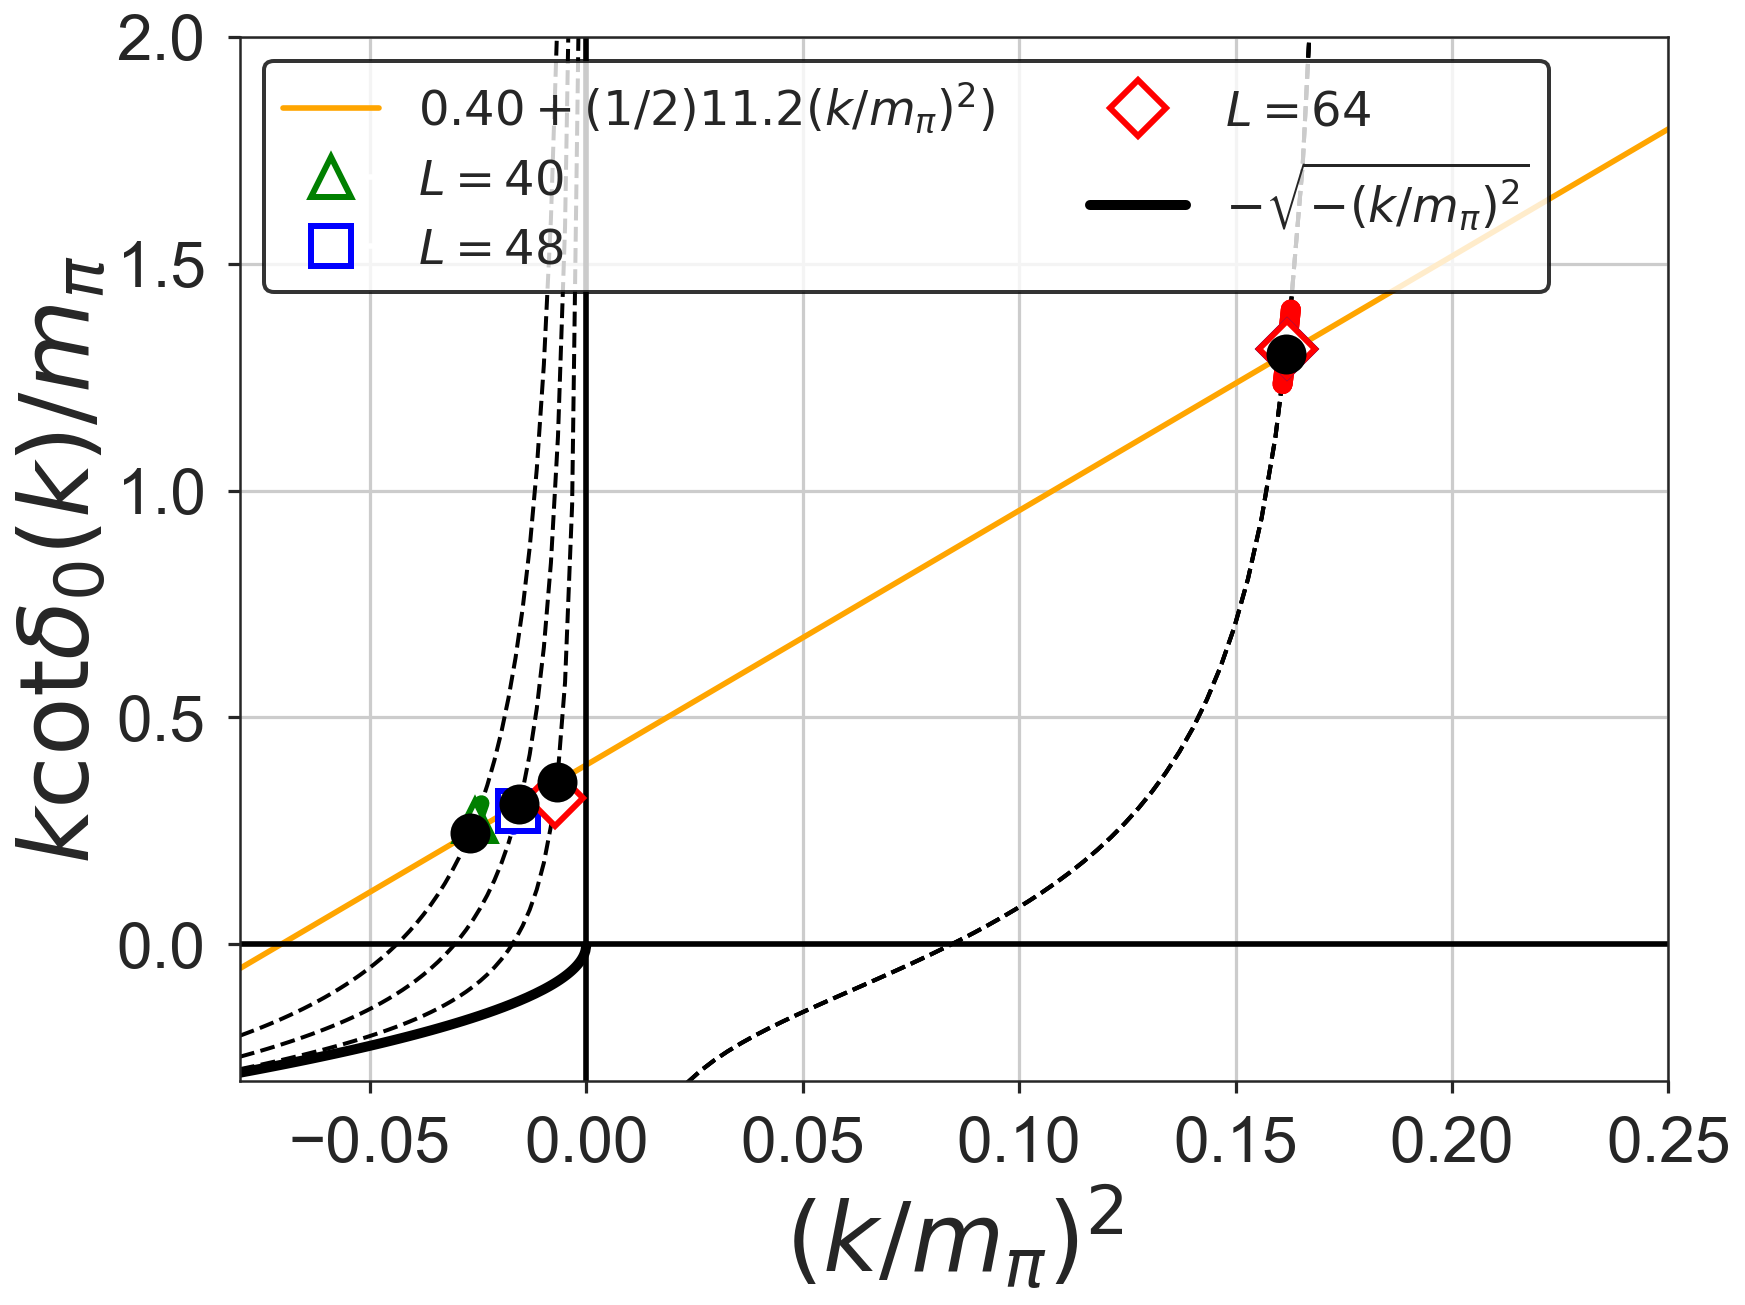

In [40]:
# minima of chisquare
check_ere_intersection(chi2s[chi2s[:,0].argmin(), 1:]) 

1.501175477212907


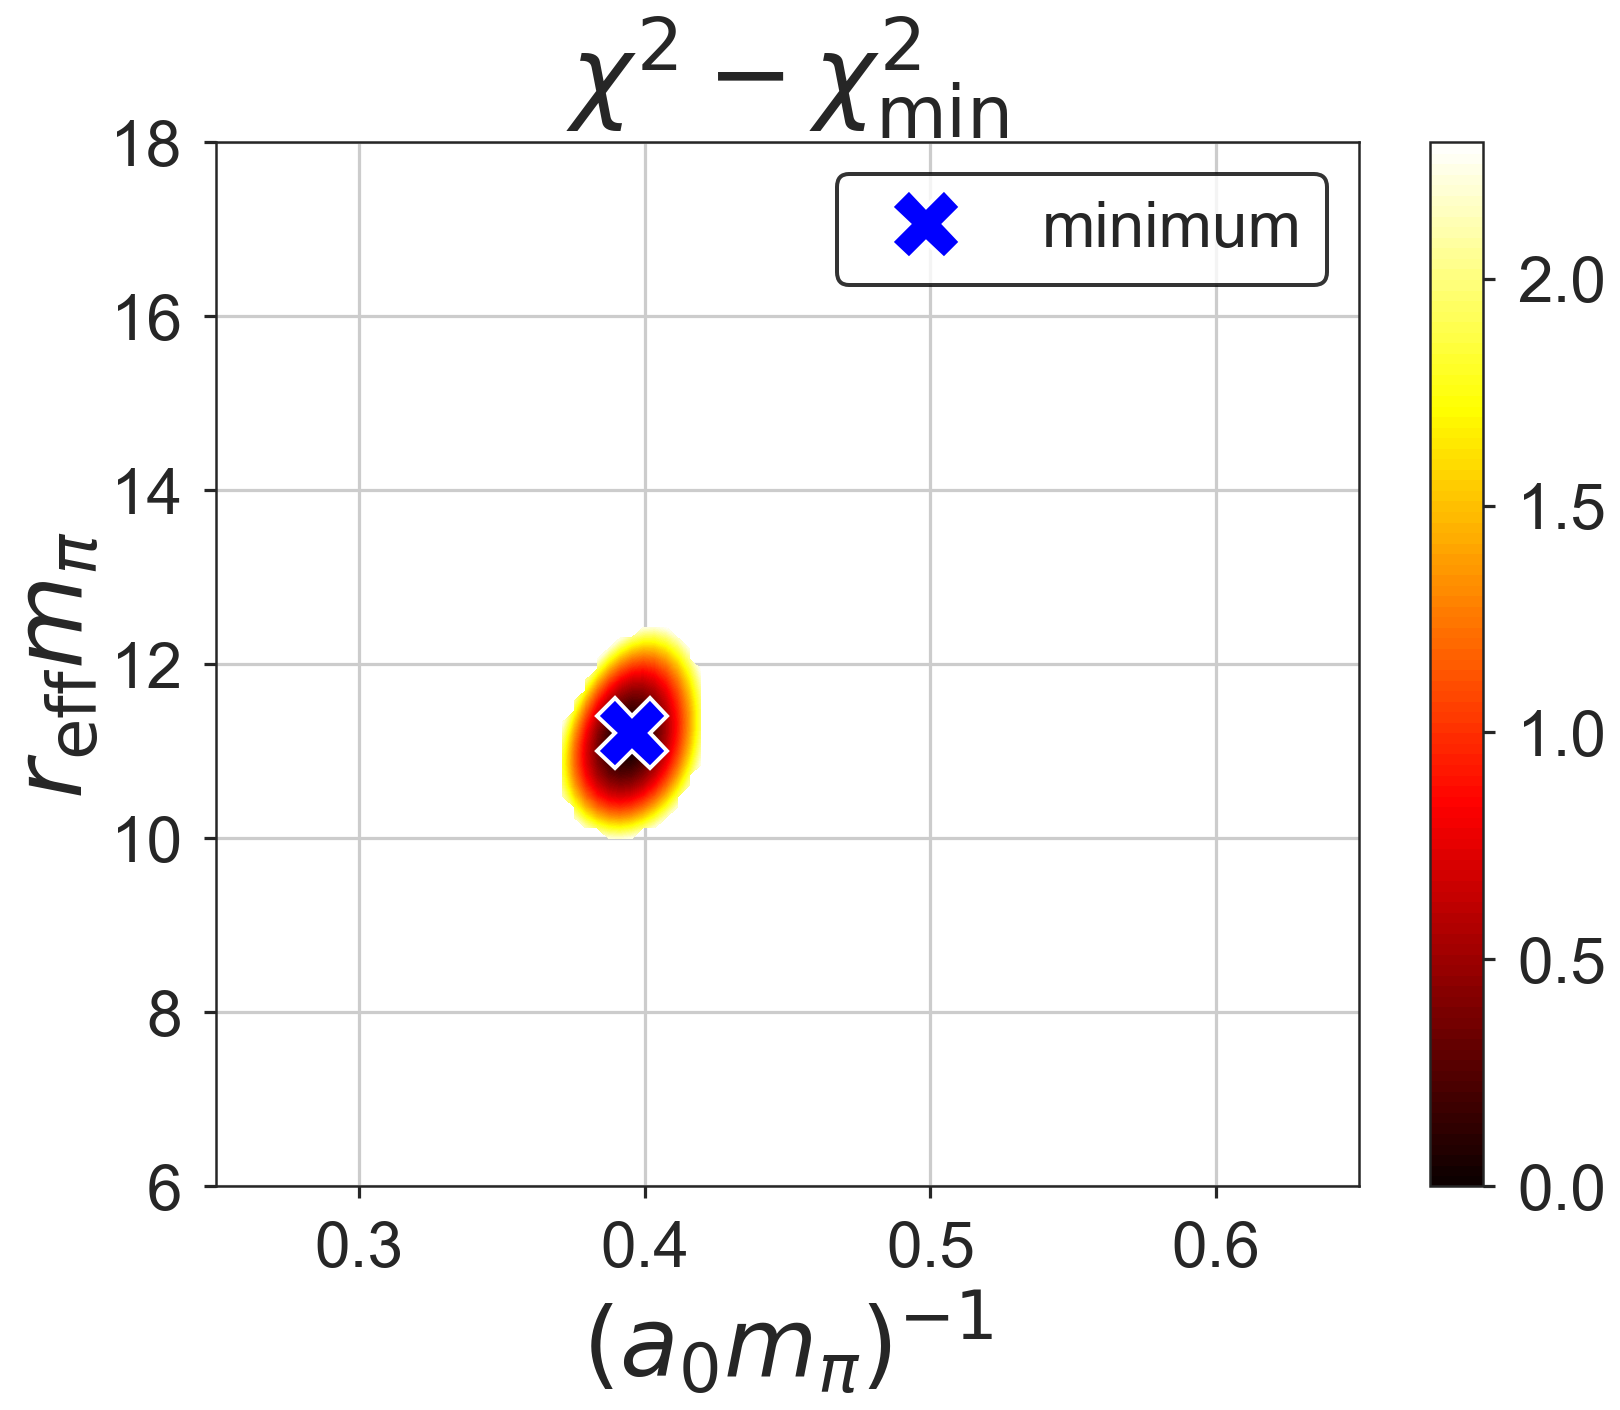

In [49]:
# plot ERE parameter contour
xx, yy = np.meshgrid(reffs, a0invs)

fig, ax = plt.subplots()
tmp = np.copy(chi2s[:,:].reshape(mesh_num,mesh_num,3))
chisq_min = tmp[:,:,0].min()
print(chisq_min)
chisq_min_ind = chi2s[:,0].argmin()
ax.plot(chi2s[chisq_min_ind,1],
        chi2s[chisq_min_ind,2], 'X', color='blue', mew=2, mec='white', ms=35,
       label='minimum')

mask = tmp[:,:,0] > chisq_min + 2.3 # 2 parameter
tmp[:,:,0][mask] = np.nan
levels = np.linspace(0, 0 + 2.3, 100)
cb = ax.contourf(tmp[:,:,1], tmp[:,:,2], tmp[:,:,0]-chisq_min, levels, cmap=cm.hot)
cb.set_clim(0,2.3)

fig.colorbar(cb, ticks=[0, 0.5, 1.0, 1.5, 2.0])

ax.set_title(r'$\chi^2 - \chi^2_\mathrm{min}$', size=52, y=1.02)
ax.set_xlabel(r'$(a_0m_\pi)^{-1}$', size=48)
ax.set_ylabel(r'$r_\mathrm{eff}m_\pi$', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
fig.savefig('../figs/finite_volume_method/ERE_param.pdf', bbox_inches='tight')

In [42]:
# generate band of ERE
ere_k2s = np.linspace(-0.08, 0.26)
mask = chi2s[:,0] <= chi2s[:,0].min() + 2.3
ere_upper = []
ere_lower = []
allowed_a0invs = chi2s[mask,1]
allowed_reffs = chi2s[mask,2]
ere_t = lambda p0, p1, k2: p0 + 0.5*p1*k2

for k2 in ere_k2s:
    ere_upper.append(np.max(ere_t(allowed_a0invs, allowed_reffs, k2)))
    ere_lower.append(np.min(ere_t(allowed_a0invs, allowed_reffs, k2)))

In [47]:
# ERE parameter 
chi2s[chi2s[:,0].argmin(),1:]

array([ 0.39545455, 11.21212121])

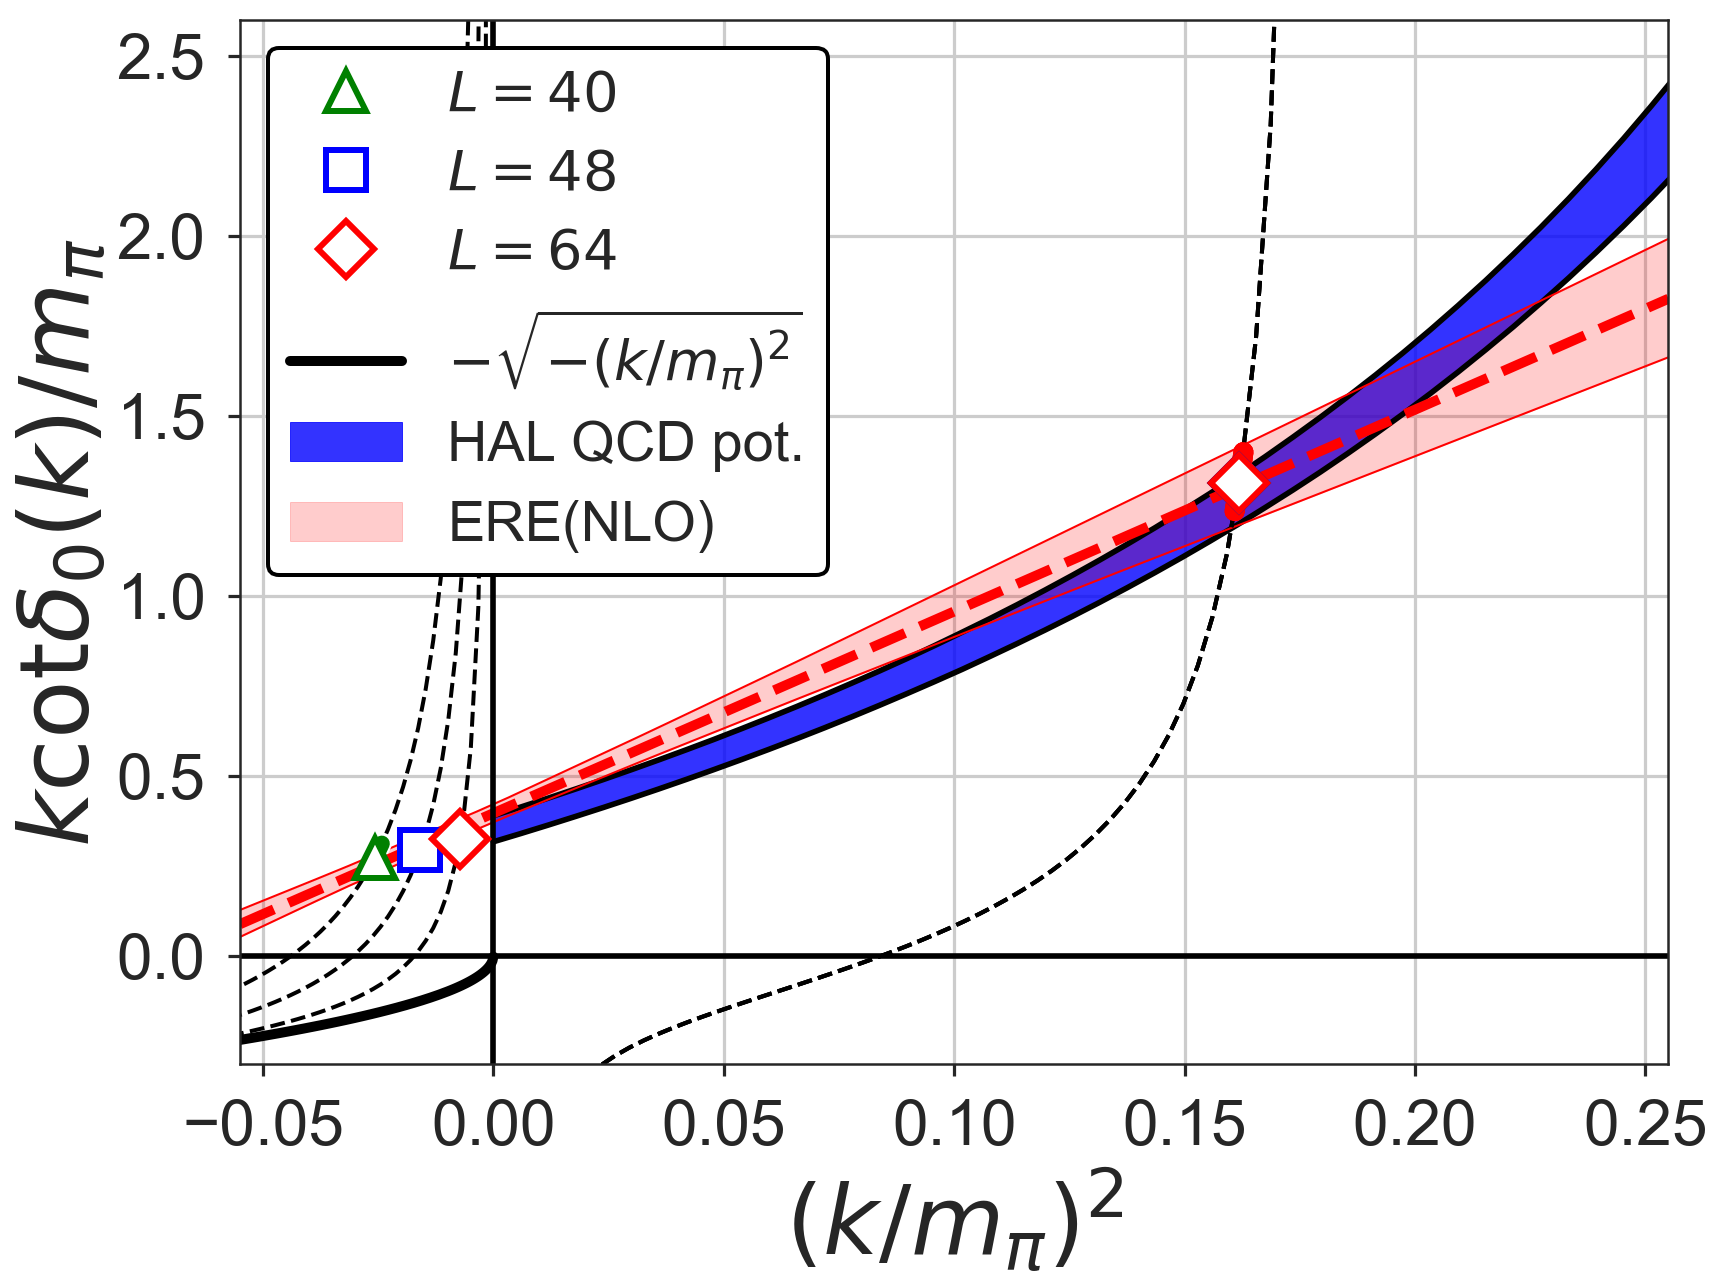

In [44]:
fig, ax = plt.subplots()

plot_kcot_from_fv_method(ax)
plot_kcot_from_pot(ax)
    
ere_min_prm = chi2s[chi2s[:,0].argmin(),1:]
ere_min = lambda k2: ere_min_prm[0] + 0.5*ere_min_prm[1]*k2
ere_xls = np.linspace(-0.055,0.255)
ax.plot(ere_xls, ere_min(ere_xls), color='red',
       lw=5, ls='--')

ax.fill_between(ere_k2s, ere_upper, ere_lower, color='red', alpha=0.2, zorder=1,
               label='ERE(NLO)')
ax.plot(ere_k2s, ere_upper, color='red', lw=1, zorder=1)
ax.plot(ere_k2s, ere_lower, color='red', lw=1, zorder=1)

ax.set_xlim(-0.055, 0.255)
ax.set_ylim(-0.3, 2.6)

ax.set_xlabel(r'$(k/m_\pi)^2$', size=48)
ax.set_ylabel(r'$k\cot\delta_0(k)/m_\pi$', size=48)
ax.axhline(0, c='black')
ax.axvline(0, c='black')
leg = ax.legend(loc='upper left', frameon=True, fontsize=28)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_alpha(1.0)
fig.savefig('../figs/finite_volume_method/kcot_vs_k2_w_ERE.pdf', bbox_inches='tight')

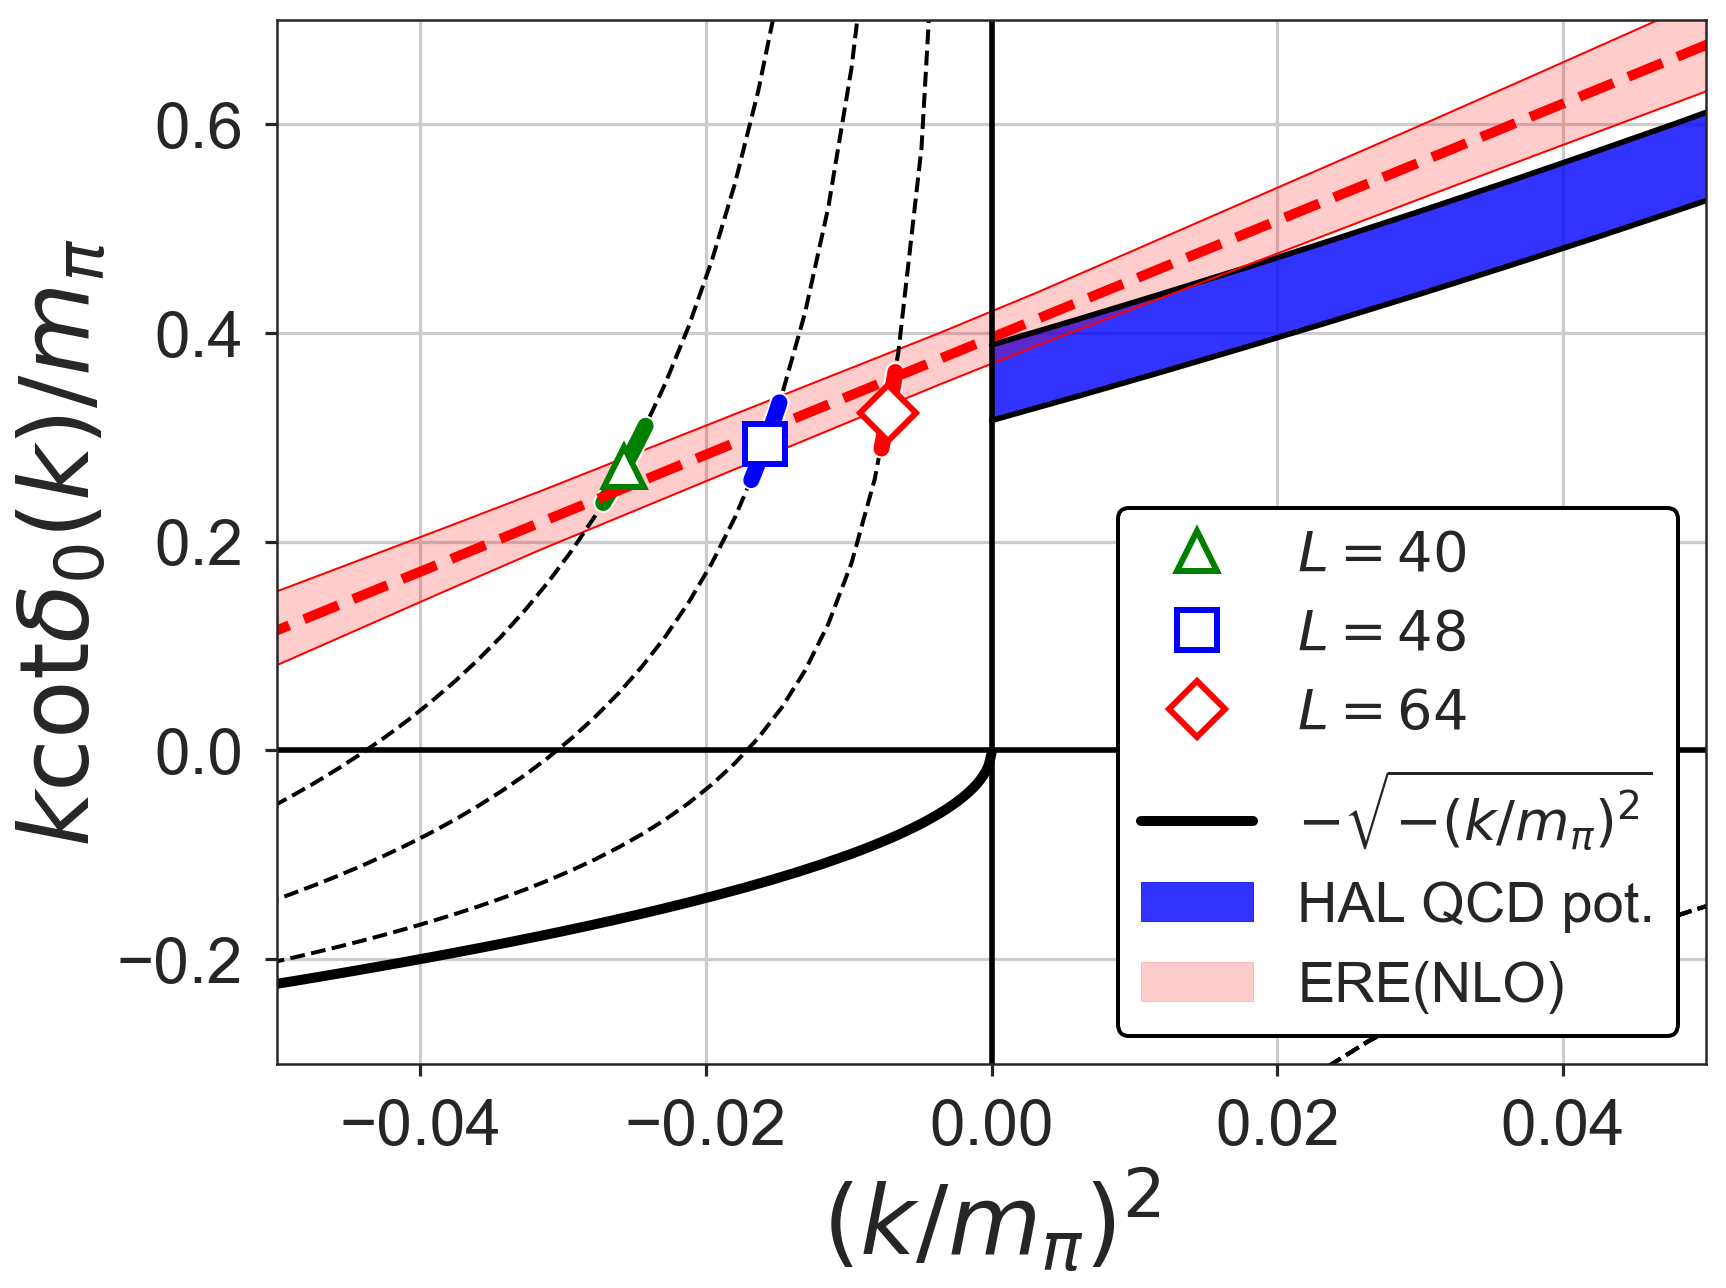

In [45]:
fig, ax = plt.subplots()

plot_kcot_from_fv_method(ax)
plot_kcot_from_pot(ax)

ere_min_prm = chi2s[chi2s[:,0].argmin(),1:]
ere_min = lambda k2: ere_min_prm[0] + 0.5*ere_min_prm[1]*k2
ere_xls = np.linspace(-0.055,0.255)
ax.plot(ere_xls, ere_min(ere_xls), color='red',
       lw=5, ls='--')

ax.fill_between(ere_k2s, ere_upper, ere_lower, color='red', alpha=0.2, zorder=1,
               label='ERE(NLO)')
ax.plot(ere_k2s, ere_upper, color='red', lw=1, zorder=1)
ax.plot(ere_k2s, ere_lower, color='red', lw=1, zorder=1)

ax.set_xlim(-0.05, 0.05)
ax.set_ylim(-0.3, 0.7)

ax.set_xlabel(r'$(k/m_\pi)^2$', size=48)
ax.set_ylabel(r'$k\cot\delta_0(k)/m_\pi$', size=48)
ax.axhline(0, c='black')
ax.axvline(0, c='black')
leg = ax.legend(loc='lower right', frameon=True, fontsize=28)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_alpha(1.0)
#fig.savefig('../figs/finite_volume_method/kcot_vs_k2_w_ERE.pdf', bbox_inches='tight')